# **Loss 1**

Set κ=1 in the quantile Huber loss to smooth small TD-errors while preserving quantile asymmetry, matching the QR-DQN setup and improving stability.”

In [ ]:
# %pip -q install gymnasium==0.29.1

import os, random, math, time, collections
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

try:
    import gymnasium as gym
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gymnasium==0.29.1"])
    import gymnasium as gym

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


In [ ]:
class Cfg:
    env_id         = "CartPole-v1"
    base_seed      = 7
    device         = "cuda" if torch.cuda.is_available() else "cpu"

    # QR-DQN
    n_quantiles    = 51
    gamma          = 0.99

    # Net / Optim
    hidden         = 128
    lr             = 5e-4
    adam_eps       = 1e-8
    grad_clip      = 10.0

    # Replay & Train
    buffer_size    = 100_000
    batch_size     = 64
    learn_start    = 1_000
    total_steps    = 50_000
    target_tau     = 1_000   # hard update every τ steps

    # Exploration
    eps_start      = 1.0
    eps_final      = 0.01
    eps_decay      = 25_000

    # What to run
    run_baseline_pinball = True   # κ=0 (plain pinball)
    run_modified_huber1  = True   # κ=1 (quantile Huber)

cfg = Cfg()
device = torch.device(cfg.device)
device


device(type='cuda')

In [ ]:
def make_env(env_id, seed):
    env = gym.make(env_id)
    env.reset(seed=seed)
    return env

# discover shapes
_tmp_env = make_env(cfg.env_id, cfg.base_seed)
obs_dim = _tmp_env.observation_space.shape[0]
n_actions = _tmp_env.action_space.n
_tmp_env.close()
obs_dim, n_actions


(4, np.int64(2))

QR-DQN network ([B, A, N])

In [ ]:
class QRDQN(nn.Module):
    def __init__(self, obs_dim, n_actions, n_quantiles, hidden=128):
        super().__init__()
        self.n_actions = n_actions
        self.n_quantiles = n_quantiles
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, n_actions * n_quantiles),
        )
    def forward(self, x):
        out = self.net(x)
        return out.view(x.size(0), self.n_actions, self.n_quantiles)


Uniform replay buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.data = collections.deque(maxlen=capacity)
    def push(self, s, a, r, ns, d):
        self.data.append((s, a, r, ns, d))
    def sample(self, batch_size, device):
        idx = np.random.randint(0, len(self.data), size=batch_size)
        s, a, r, ns, d = zip(*(self.data[i] for i in idx))
        return (
            torch.tensor(np.array(s), dtype=torch.float32, device=device),
            torch.tensor(np.array(a), dtype=torch.int64,   device=device),
            torch.tensor(np.array(r), dtype=torch.float32, device=device),
            torch.tensor(np.array(ns),dtype=torch.float32, device=device),
            torch.tensor(np.array(d), dtype=torch.float32, device=device),
        )
    def __len__(self): return len(self.data)


τ midpoints + both losses (pinball κ=0, huber κ=1)

In [ ]:
def quantile_midpoints(n_quantiles: int, device=None, dtype=torch.float32):
    return (torch.arange(n_quantiles, device=device, dtype=dtype) + 0.5) / n_quantiles

def quantile_loss_general(pred_q, target_q, taus, kappa: float, reduction="mean"):
    """
    pred_q:   [B, N]
    target_q: [B, N']  (we use N'=N here)
    taus:     [N]
    kappa:    0.0 -> pinball; 1.0 -> quantile Huber with κ=1
    """
    B, N  = pred_q.shape
    pred  = pred_q.unsqueeze(2)
    tgt   = target_q.unsqueeze(1)
    u     = tgt - pred
    abs_u = u.abs()

    if kappa > 0.0:
        huber = torch.where(abs_u <= kappa, 0.5*(u**2), kappa*(abs_u - 0.5*kappa))
        huber = huber / kappa
    else:
        huber = abs_u

    taus = taus.view(1, N, 1)
    indicator = (u.detach() < 0.0).float()
    quantile_weight = (taus - indicator).abs()
    loss = quantile_weight * huber

    if reduction == "mean": return loss.mean()
    if reduction == "sum":  return loss.sum()
    return loss

def pinball_loss(pred_q, target_q, taus):     # κ = 0
    return quantile_loss_general(pred_q, target_q, taus, kappa=0.0, reduction="mean")

def huber_quantile_loss(pred_q, target_q, taus):  # κ = 1
    return quantile_loss_general(pred_q, target_q, taus, kappa=1.0, reduction="mean")


Policy, targets, and a self-contained trainer

In [ ]:
def epsilon_by_step(step, cfg):
    return float(cfg.eps_final + (cfg.eps_start - cfg.eps_final) * max(0.0, 1.0 - step / cfg.eps_decay))

@torch.no_grad()
def act_epsilon_greedy(state, online, epsilon, device):
    if random.random() < epsilon:
        return random.randrange(online.n_actions)
    s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    q = online(s)
    q_mean = q.mean(2)
    return int(q_mean.argmax(1).item())

def compute_loss(batch, online, target, taus, cfg, loss_mode: str):
    s, a, r, ns, d = batch
    B = s.size(0)
    q_all = online(s)
    q_chosen = q_all.gather(1, a.view(B,1,1).expand(B,1,cfg.n_quantiles)).squeeze(1)

    with torch.no_grad():
        next_q_online = online(ns)
        next_a = next_q_online.mean(2).argmax(1, keepdim=True)
        next_q_target = target(ns).gather(1, next_a.unsqueeze(-1).expand(-1,-1,cfg.n_quantiles)).squeeze(1)
        target_q = r.unsqueeze(1) + (1.0 - d.unsqueeze(1)) * cfg.gamma * next_q_target

    if   loss_mode == "pinball": return pinball_loss(q_chosen, target_q, taus)
    elif loss_mode == "huber1":  return huber_quantile_loss(q_chosen, target_q, taus)
    else: raise ValueError("loss_mode must be 'pinball' or 'huber1'")

def train_one(run_name: str, loss_mode: str, seed: int, cfg=cfg):
    print(f"=== Training {run_name} | loss={loss_mode} ===")
    set_seed(seed)
    env = make_env(cfg.env_id, seed)
    replay = ReplayBuffer(cfg.buffer_size)

    online = QRDQN(obs_dim, n_actions, cfg.n_quantiles, cfg.hidden).to(device)
    target = QRDQN(obs_dim, n_actions, cfg.n_quantiles, cfg.hidden).to(device)
    target.load_state_dict(online.state_dict())

    optimizer = torch.optim.Adam(online.parameters(), lr=cfg.lr, eps=cfg.adam_eps)
    taus = quantile_midpoints(cfg.n_quantiles, device=device)

    returns = []
    s, _ = env.reset(seed=seed)
    for step in range(1, cfg.total_steps + 1):
        eps = epsilon_by_step(step, cfg)
        a = act_epsilon_greedy(s, online, eps, device)
        ns, r, term, trunc, _ = env.step(a)
        done = term or trunc

        replay.push(s, a, r, ns, float(done))
        s = ns

        if len(replay) >= cfg.learn_start:
            batch = replay.sample(cfg.batch_size, device)
            loss = compute_loss(batch, online, target, taus, cfg, loss_mode)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            if cfg.grad_clip is not None:
                nn.utils.clip_grad_norm_(online.parameters(), cfg.grad_clip)
            optimizer.step()

        if step % cfg.target_tau == 0:
            target.load_state_dict(online.state_dict())

        if done:
            with torch.no_grad():
                probe_ret = 0.0
                s_eval, _ = env.reset()
                for _ in range(500):
                    a_eval = act_epsilon_greedy(s_eval, online, 0.0, device)
                    s_eval, r_eval, te, tr, _ = env.step(a_eval)
                    probe_ret += r_eval
                    if te or tr: break
            returns.append(probe_ret)
            s, _ = env.reset()

        if step % 5000 == 0:
            recent = np.mean(returns[-10:]) if returns else 0.0
            print(f"[{run_name}] step {step:6d} | buffer={len(replay):6d} | eps={eps:.03f} | recent(10)={recent:.1f}")

    # Final evaluation
    def evaluate(episodes=10):
        scores = []
        for ep in range(episodes):
            s_eval, _ = env.reset(seed=seed + 1000 + ep)
            total = 0.0
            for _ in range(1000):
                a_eval = act_epsilon_greedy(s_eval, online, 0.0, device)
                s_eval, r_eval, te, tr, _ = env.step(a_eval)
                total += r_eval
                if te or tr: break
            scores.append(total)
        return float(np.mean(scores)), scores

    mean_eval, eval_scores = evaluate(episodes=10)
    env.close()

    ckpt_path = f"/content/{run_name}.pt"
    torch.save({"model": online.state_dict(), "cfg": vars(cfg),
                "obs_dim": obs_dim, "n_actions": n_actions}, ckpt_path)
    print(f"Saved: {ckpt_path} | Mean greedy eval (10 eps): {mean_eval:.2f}")

    return {"name": run_name, "returns": returns, "mean_eval": mean_eval, "ckpt": ckpt_path}


Run baseline and/or modified, compare & plot

=== Training qrdqn_pinball_k0 | loss=pinball ===
[qrdqn_pinball_k0] step   5000 | buffer=  5000 | eps=0.802 | recent(10)=169.4
[qrdqn_pinball_k0] step  10000 | buffer= 10000 | eps=0.604 | recent(10)=157.7
[qrdqn_pinball_k0] step  15000 | buffer= 15000 | eps=0.406 | recent(10)=138.5
[qrdqn_pinball_k0] step  20000 | buffer= 20000 | eps=0.208 | recent(10)=227.0
[qrdqn_pinball_k0] step  25000 | buffer= 25000 | eps=0.010 | recent(10)=234.7
[qrdqn_pinball_k0] step  30000 | buffer= 30000 | eps=0.010 | recent(10)=174.0
[qrdqn_pinball_k0] step  35000 | buffer= 35000 | eps=0.010 | recent(10)=187.5
[qrdqn_pinball_k0] step  40000 | buffer= 40000 | eps=0.010 | recent(10)=164.0
[qrdqn_pinball_k0] step  45000 | buffer= 45000 | eps=0.010 | recent(10)=126.2
[qrdqn_pinball_k0] step  50000 | buffer= 50000 | eps=0.010 | recent(10)=122.0
Saved: /content/qrdqn_pinball_k0.pt | Mean greedy eval (10 eps): 121.00
=== Training qrdqn_huber_k1 | loss=huber1 ===
[qrdqn_huber_k1] step   5000 | buffer=  5000 | eps=0.

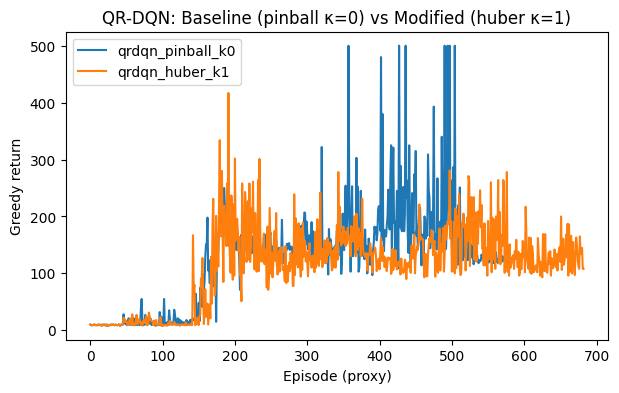

In [ ]:
results = []

if cfg.run_baseline_pinball:
    res_base = train_one(run_name="qrdqn_pinball_k0", loss_mode="pinball", seed=cfg.base_seed)
    results.append(res_base)

if cfg.run_modified_huber1:
    res_mod = train_one(run_name="qrdqn_huber_k1", loss_mode="huber1", seed=cfg.base_seed)
    results.append(res_mod)

for r in results:
    print(f"{r['name']}: mean_eval={r['mean_eval']:.2f}, ckpt={r['ckpt']}")

try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,4))
    for r in results:
        plt.plot(r["returns"], label=r["name"])
    plt.xlabel("Episode (proxy)")
    plt.ylabel("Greedy return")
    plt.title("QR-DQN: Baseline (pinball κ=0) vs Modified (huber κ=1)")
    plt.legend()
    plt.show()
except Exception as e:
    print("Plot error:", e)


quick load & eval a checkpoint

In [ ]:
import torch, numpy as np

def safe_load_state(ckpt_path, device):
    try:
        payload = torch.load(ckpt_path, map_location=device)
    except Exception:
        try:
            torch.serialization.add_safe_globals([np._core.multiarray.scalar])
            payload = torch.load(ckpt_path, map_location=device)
        except Exception:
            payload = torch.load(ckpt_path, map_location=device, weights_only=False)

    if isinstance(payload, dict) and "model" in payload:
        state_dict = payload["model"]
    else:
        state_dict = payload
    return state_dict

def load_and_eval(ckpt_path, episodes=10):
    env = make_env(cfg.env_id, cfg.base_seed + 2025)
    model = QRDQN(obs_dim, n_actions, cfg.n_quantiles, cfg.hidden).to(device)

    state_dict = safe_load_state(ckpt_path, device)
    model.load_state_dict(state_dict)

    @torch.no_grad()
    def greedy_episode():
        s, _ = env.reset()
        total = 0.0
        for _ in range(1000):
            a = act_epsilon_greedy(s, model, 0.0, device)
            s, r, term, trunc, _ = env.step(a)
            total += r
            if term or trunc:
                break
        return total

    scores = [greedy_episode() for _ in range(episodes)]
    env.close()
    return float(np.mean(scores)), scores

for r in results:
    mean_eval, _ = load_and_eval(r["ckpt"], episodes=1000)
    print(f"[Reload check] {r['name']}: mean_eval={mean_eval:.2f}")


[Reload check] qrdqn_pinball_k0: mean_eval=121.41
[Reload check] qrdqn_huber_k1: mean_eval=101.43


Multi-seed runner (current settings)

In [ ]:
def run_experiment(loss_mode, seeds, cfg_template):
    res = []
    for s in seeds:
        cfg_local = copy.deepcopy(cfg_template)
        out = train_one(run_name=f"{loss_mode}_seed{s}", loss_mode=loss_mode, seed=s, cfg=cfg_local)
        res.append(out["mean_eval"])
    return np.array(res, dtype=np.float32)

In [ ]:
import numpy as np, copy, time

def run_experiment(loss_mode, seeds, cfg_template):
    res = []
    for s in seeds:
        cfg_local = copy.deepcopy(cfg_template)
        out = train_one(run_name=f"{loss_mode}_seed{s}", loss_mode=loss_mode, seed=s, cfg=cfg_local)
        res.append(out["mean_eval"])
    return np.array(res, dtype=np.float32)

seeds = [7, 8, 9, 10, 11]

print("=== Multi-seed (current config) ===")
base_scores = run_experiment("pinball", seeds, cfg)
hub1_scores = run_experiment("huber1", seeds, cfg)

def summarize(name, scores):
    print(f"{name}: mean={scores.mean():.2f}  median={np.median(scores):.2f}  std={scores.std(ddof=1):.2f}  n={len(scores)}  scores={scores.round(1)}")

summarize("Baseline κ=0", base_scores)
summarize("Huber κ=1",  hub1_scores)


=== Multi-seed (current config) ===
=== Training pinball_seed7 | loss=pinball ===
[pinball_seed7] step   5000 | buffer=  5000 | eps=0.802 | recent(10)=169.4
[pinball_seed7] step  10000 | buffer= 10000 | eps=0.604 | recent(10)=157.7
[pinball_seed7] step  15000 | buffer= 15000 | eps=0.406 | recent(10)=138.5
[pinball_seed7] step  20000 | buffer= 20000 | eps=0.208 | recent(10)=227.0
[pinball_seed7] step  25000 | buffer= 25000 | eps=0.010 | recent(10)=234.7
[pinball_seed7] step  30000 | buffer= 30000 | eps=0.010 | recent(10)=174.0
[pinball_seed7] step  35000 | buffer= 35000 | eps=0.010 | recent(10)=187.5
[pinball_seed7] step  40000 | buffer= 40000 | eps=0.010 | recent(10)=164.0
[pinball_seed7] step  45000 | buffer= 45000 | eps=0.010 | recent(10)=126.2
[pinball_seed7] step  50000 | buffer= 50000 | eps=0.010 | recent(10)=122.0
Saved: /content/pinball_seed7.pt | Mean greedy eval (10 eps): 121.00
=== Training pinball_seed8 | loss=pinball ===
[pinball_seed8] step   5000 | buffer=  5000 | eps=0.8

Stability-tuned config (still loss-only ablation)

In [ ]:
import copy
cfg_tuned = copy.deepcopy(cfg)
cfg_tuned.total_steps = 100_000
cfg_tuned.eps_decay   = 50_000
cfg_tuned.target_tau  = 500

print("=== Multi-seed (tuned config) ===")
base_scores_tuned = run_experiment("pinball", seeds, cfg_tuned)
hub1_scores_tuned = run_experiment("huber1",  seeds, cfg_tuned)

summarize("Baseline κ=0 (tuned)", base_scores_tuned)
summarize("Huber κ=1 (tuned)",    hub1_scores_tuned)


=== Multi-seed (tuned config) ===
=== Training pinball_seed7 | loss=pinball ===
[pinball_seed7] step   5000 | buffer=  5000 | eps=0.901 | recent(10)=245.0
[pinball_seed7] step  10000 | buffer= 10000 | eps=0.802 | recent(10)=155.6
[pinball_seed7] step  15000 | buffer= 15000 | eps=0.703 | recent(10)=163.7
[pinball_seed7] step  20000 | buffer= 20000 | eps=0.604 | recent(10)=341.6
[pinball_seed7] step  25000 | buffer= 25000 | eps=0.505 | recent(10)=324.9
[pinball_seed7] step  30000 | buffer= 30000 | eps=0.406 | recent(10)=200.7
[pinball_seed7] step  35000 | buffer= 35000 | eps=0.307 | recent(10)=135.5
[pinball_seed7] step  40000 | buffer= 40000 | eps=0.208 | recent(10)=122.3
[pinball_seed7] step  45000 | buffer= 45000 | eps=0.109 | recent(10)=130.3
[pinball_seed7] step  50000 | buffer= 50000 | eps=0.010 | recent(10)=169.7
[pinball_seed7] step  55000 | buffer= 55000 | eps=0.010 | recent(10)=156.5
[pinball_seed7] step  60000 | buffer= 60000 | eps=0.010 | recent(10)=129.7
[pinball_seed7] step

In [ ]:
# Re-evaluate any saved checkpoint with more test episodes (e.g., 30)
mean_eval_30, scores_30 = load_and_eval("/content/huber1_seed10.pt", episodes=300)
print("Re-eval baseline (30 eps):", mean_eval_30)

Re-eval baseline (30 eps): 500.0


In [ ]:
# Re-evaluate any saved checkpoint with more test episodes (e.g., 30)
mean_eval_30, scores_30 = load_and_eval("/content/pinball_seed10.pt", episodes=300)
print("Re-eval baseline (30 eps):", mean_eval_30)

Re-eval baseline (30 eps): 500.0


# Make CartPole noisy/sticky

Noisy/sticky wrappers

In [ ]:
import gymnasium as gym
import numpy as np
from gymnasium import Wrapper

class StickyAction(Wrapper):
    """With prob p, repeat the previous action (Atari-style stickiness)."""
    def __init__(self, env, p=0.25):
        super().__init__(env)
        self.p = p
        self.last_action = None
    def reset(self, **kwargs):
        self.last_action = None
        return self.env.reset(**kwargs)
    def step(self, action):
        if self.last_action is not None and np.random.rand() < self.p:
            action = self.last_action
        self.last_action = action
        return self.env.step(action)

class RewardNoise(Wrapper):
    """Add zero-mean Gaussian noise to reward."""
    def __init__(self, env, sigma=0.25, clip=(-1.0, 1.0)):
        super().__init__(env)
        self.sigma = sigma
        self.clip = clip
    def step(self, action):
        obs, r, term, trunc, info = self.env.step(action)
        r_noisy = float(np.clip(r + np.random.randn() * self.sigma, *self.clip))
        return obs, r_noisy, term, trunc, info

class ObsNoise(Wrapper):
    """Add small Gaussian noise to observations (state)."""
    def __init__(self, env, sigma=0.02):
        super().__init__(env)
        self.sigma = sigma
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        obs = obs + np.random.randn(*obs.shape) * self.sigma
        return obs.astype(np.float32), info
    def step(self, action):
        obs, r, term, trunc, info = self.env.step(action)
        obs = obs + np.random.randn(*obs.shape) * self.sigma
        return obs.astype(np.float32), r, term, trunc, info


In [ ]:
def make_env(env_id, seed):
    env = gym.make(env_id)
    env.reset(seed=seed)
    env = StickyAction(env, p=0.25)
    env = RewardNoise(env, sigma=0.25, clip=(-1.0, 1.0))
    return env


#MinAtar Breakout

In [ ]:
cfg.device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(cfg.device)
print("Using:", device)

Using: cuda


In [ ]:
# Minimal, fast Atari-like
%pip -q install minatar



MinAtar

In [ ]:
import numpy as np
from minatar import Environment

class MinAtarGymLike:
    """
    Tiny adapter that mimics the subset of Gymnasium API we use.
    obs: float32 tensor in shape [C,H,W]; rewards are floats.
    """
    def __init__(self, game="breakout", sticky_action_prob=0.1, seed=0):
        self.env = Environment(game, sticky_action_prob=sticky_action_prob)
        self.game = game
        self.n_actions = self.env.num_actions()
        self.action_space = type("A", (), {"n": self.n_actions})
        self.observation_space = type("O", (), {"shape": (self.env.state().shape[2], 10, 10)})
        self._seed = seed
        self.rng = np.random.RandomState(seed)

    def reset(self, seed=None):
        if seed is not None:
            self.rng = np.random.RandomState(seed)
        self.env.reset()
        s = self.env.state()
        s = np.transpose(s, (2,0,1)).astype(np.float32)
        return s, {}

    def step(self, a):
        r, done = self.env.act(a)
        s = self.env.state()
        s = np.transpose(s, (2,0,1)).astype(np.float32)
        return s, float(r), bool(done), False, {}

    def close(self):
        pass

def make_minatar_env(seed=0, game="breakout", sticky=0.1):
    env = MinAtarGymLike(game=game, sticky_action_prob=sticky, seed=seed)
    return env

m_env = make_minatar_env(seed=7, game="breakout", sticky=0.1)
obs0, _ = m_env.reset()
minatar_obs_shape = obs0.shape
minatar_actions = m_env.action_space.n
m_env.close()
minatar_obs_shape, minatar_actions

((4, 10, 10), 6)

Small CNN QR-DQN head (for [B,C,H,W] input)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class QRDQNConv(nn.Module):
    def __init__(self, in_channels, n_actions, n_quantiles, hidden=128):
        super().__init__()
        self.n_actions = n_actions
        self.n_quantiles = n_quantiles
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1), nn.ReLU(),
        )
        feat_size = 64 * 6 * 6
        self.fc = nn.Sequential(
            nn.Linear(feat_size, hidden), nn.ReLU(),
            nn.Linear(hidden, n_actions * n_quantiles),
        )
    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        out = self.fc(h)
        return out.view(x.size(0), self.n_actions, self.n_quantiles)


MinAtar config + minor training differences

In [ ]:
import copy
cfg_m = copy.deepcopy(cfg)
cfg_m.env_id = "MinAtar-breakout"
cfg_m.total_steps = 200_000
cfg_m.learn_start = 10_000
cfg_m.eps_decay = 150_000
cfg_m.target_tau = 2_000
cfg_m.batch_size = 64
cfg_m.lr = 1e-4

# Build MinAtar env & networks
minatar_env = make_minatar_env(seed=cfg.base_seed, game="breakout", sticky=0.1)
C,H,W = minatar_obs_shape
nA = minatar_actions

online_m = QRDQNConv(C, nA, cfg.n_quantiles, hidden=128).to(device)
target_m = QRDQNConv(C, nA, cfg.n_quantiles, hidden=128).to(device)
target_m.load_state_dict(online_m.state_dict())
optimizer_m = torch.optim.Adam(online_m.parameters(), lr=cfg_m.lr, eps=cfg_m.adam_eps)
taus_m = quantile_midpoints(cfg_m.n_quantiles, device=device)


Train loop specialized to MinAtar (reuses loss functions)

In [ ]:
def act_eps_minatar(state, online, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(0, online.n_actions)
    s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    q = online(s)
    return int(q.mean(2).argmax(1).item())

class Replay4D:
    def __init__(self, capacity, obs_shape):
        self.data = collections.deque(maxlen=capacity)
        self.obs_shape = obs_shape
    def push(self, s,a,r,ns,d):
        self.data.append((s.copy(), a, r, ns.copy(), d))
    def sample(self, B):
        idx = np.random.randint(0, len(self.data), size=B)
        s,a,r,ns,d = zip(*(self.data[i] for i in idx))
        s  = torch.tensor(np.stack(s),  dtype=torch.float32, device=device)
        ns = torch.tensor(np.stack(ns), dtype=torch.float32, device=device)
        a  = torch.tensor(np.array(a),  dtype=torch.int64,   device=device)
        r  = torch.tensor(np.array(r),  dtype=torch.float32, device=device)
        d  = torch.tensor(np.array(d),  dtype=torch.float32, device=device)
        return s,a,r,ns,d
    def __len__(self): return len(self.data)

replay_m = Replay4D(cfg_m.buffer_size, (C,H,W))

def compute_loss_minatar(batch, online, target, taus, cfg, loss_mode):
    s,a,r,ns,d = batch
    B = s.size(0)
    q_all = online(s)
    q_chosen = q_all.gather(1, a.view(B,1,1).expand(B,1,cfg.n_quantiles)).squeeze(1)
    with torch.no_grad():
        next_q_online = online(ns)
        next_a = next_q_online.mean(2).argmax(1, keepdim=True)
        next_q_target = target(ns).gather(1, next_a.unsqueeze(-1).expand(-1,-1, cfg.n_quantiles)).squeeze(1)
        target_q = r.unsqueeze(1) + (1.0 - d.unsqueeze(1)) * cfg.gamma * next_q_target
    if loss_mode == "pinball":
        return pinball_loss(q_chosen, target_q, taus)
    else:
        return huber_quantile_loss(q_chosen, target_q, taus)

def train_minatar(run_name, loss_mode, cfg_local):
    print(f"=== MinAtar {run_name} | loss={loss_mode} ===")
    env = make_minatar_env(seed=cfg.base_seed, game="breakout", sticky=0.1)
    online = QRDQNConv(C, nA, cfg_local.n_quantiles, hidden=128).to(device)
    target = QRDQNConv(C, nA, cfg_local.n_quantiles, hidden=128).to(device)
    target.load_state_dict(online.state_dict())
    opt = torch.optim.Adam(online.parameters(), lr=cfg_local.lr, eps=cfg_local.adam_eps)
    taus = quantile_midpoints(cfg_local.n_quantiles, device=device)
    rb = Replay4D(cfg_local.buffer_size, (C,H,W))

    returns = []
    s, _ = env.reset()
    for step in range(1, cfg_local.total_steps+1):
        eps = epsilon_by_step(step, cfg_local)
        a = act_eps_minatar(s, online, eps)
        ns, r, term, trunc, _ = env.step(a)
        d = float(term or trunc)
        rb.push(s, a, r, ns, d)
        s = ns

        if len(rb) >= cfg_local.learn_start:
            batch = rb.sample(cfg_local.batch_size)
            loss = compute_loss_minatar(batch, online, target, taus, cfg_local, loss_mode)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(online.parameters(), cfg_local.grad_clip)
            opt.step()

        if step % cfg_local.target_tau == 0:
            target.load_state_dict(online.state_dict())

        if term or trunc:
            gret = 0.0
            s_eval, _ = env.reset()
            for _ in range(1000):
                a_eval = act_eps_minatar(s_eval, online, 0.0)
                s_eval, r_eval, te, tr, _ = env.step(a_eval)
                gret += r_eval
                if te or tr: break
            returns.append(gret)
            s, _ = env.reset()

        if step % 20000 == 0:
            last = np.mean(returns[-10:]) if returns else 0.0
            print(f"[{run_name}] step={step} rb={len(rb)} eps={eps:.3f} recent(10)={last:.2f}")

    # Save & final quick eval
    path = f"/content/{run_name}.pt"
    torch.save(online.state_dict(), path)
    print("Saved:", path, "| episodes logged:", len(returns))
    return returns

# Run baseline vs κ=1 on MinAtar
ret_base_m = train_minatar("minatar_breakout_pinball_k0", "pinball", cfg_m)
ret_h1_m   = train_minatar("minatar_breakout_huber_k1",   "huber1",  cfg_m)


=== MinAtar minatar_breakout_pinball_k0 | loss=pinball ===
[minatar_breakout_pinball_k0] step=20000 rb=20000 eps=0.868 recent(10)=0.70
[minatar_breakout_pinball_k0] step=40000 rb=40000 eps=0.736 recent(10)=1.80
[minatar_breakout_pinball_k0] step=60000 rb=60000 eps=0.604 recent(10)=3.00
[minatar_breakout_pinball_k0] step=80000 rb=80000 eps=0.472 recent(10)=3.60
[minatar_breakout_pinball_k0] step=100000 rb=100000 eps=0.340 recent(10)=6.10
[minatar_breakout_pinball_k0] step=120000 rb=100000 eps=0.208 recent(10)=5.30
[minatar_breakout_pinball_k0] step=140000 rb=100000 eps=0.076 recent(10)=8.80
[minatar_breakout_pinball_k0] step=160000 rb=100000 eps=0.010 recent(10)=6.50
[minatar_breakout_pinball_k0] step=180000 rb=100000 eps=0.010 recent(10)=6.90
[minatar_breakout_pinball_k0] step=200000 rb=100000 eps=0.010 recent(10)=7.40
Saved: /content/minatar_breakout_pinball_k0.pt | episodes logged: 7375
=== MinAtar minatar_breakout_huber_k1 | loss=huber1 ===
[minatar_breakout_huber_k1] step=20000 rb=

Plot the MinAtar learning curves

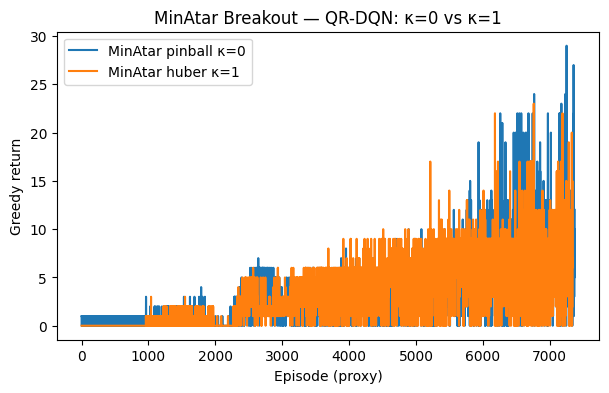

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(ret_base_m, label="MinAtar pinball κ=0")
plt.plot(ret_h1_m,   label="MinAtar huber κ=1")
plt.xlabel("Episode (proxy)")
plt.ylabel("Greedy return")
plt.title("MinAtar Breakout — QR-DQN: κ=0 vs κ=1")
plt.legend(); plt.show()


Greedy evaluation helper (ε=0) for MinAtar

In [ ]:
import numpy as np
import torch

@torch.no_grad()
def eval_minatar_checkpoint(ckpt_path, episodes=30, seed_base=12345, game="breakout", sticky=0.1):
    """
    Loads a saved QRDQNConv state_dict and evaluates greedy performance (epsilon=0)
    over `episodes` episodes on MinAtar `game`.
    Returns: mean_return, std_return, list_of_returns
    """
    # fresh env to discover shapes
    env = make_minatar_env(seed=seed_base, game=game, sticky=sticky)
    obs0, _ = env.reset()
    C, H, W = obs0.shape
    nA = env.action_space.n

    # build model and load weights
    model = QRDQNConv(C, nA, cfg_m.n_quantiles, hidden=128).to(device)
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)

    def greedy_episode(seed_offset=0):
        s, _ = env.reset(seed=seed_base + seed_offset)  # vary starts
        total = 0.0
        for _ in range(5000):  # big cap; episodes end when env says done
            a = act_eps_minatar(s, model, epsilon=0.0)  # greedy (ε=0)
            s, r, term, trunc, _ = env.step(a)
            total += r
            if term or trunc:
                break
        return float(total)

    scores = [greedy_episode(ep) for ep in range(episodes)]
    env.close()
    scores = np.array(scores, dtype=np.float32)
    return float(scores.mean()), float(scores.std(ddof=1)), scores.tolist()


Evaluate both checkpoints and print results

In [ ]:
ckpt_base = "/content/minatar_breakout_pinball_k0.pt"
ckpt_h1   = "/content/minatar_breakout_huber_k1.pt"

mean_b, std_b, scores_b = eval_minatar_checkpoint(ckpt_base, episodes=1000)
mean_h, std_h, scores_h = eval_minatar_checkpoint(ckpt_h1,   episodes=1000)

print(f"Baseline (pinball κ=0): mean={mean_b:.2f}  std={std_b:.2f}  n={len(scores_b)}")
print(f"Huber (κ=1):           mean={mean_h:.2f}  std={std_h:.2f}  n={len(scores_h)}")


Baseline (pinball κ=0): mean=8.02  std=3.22  n=1000
Huber (κ=1):           mean=10.61  std=5.67  n=1000


Plot per-episode eval scores

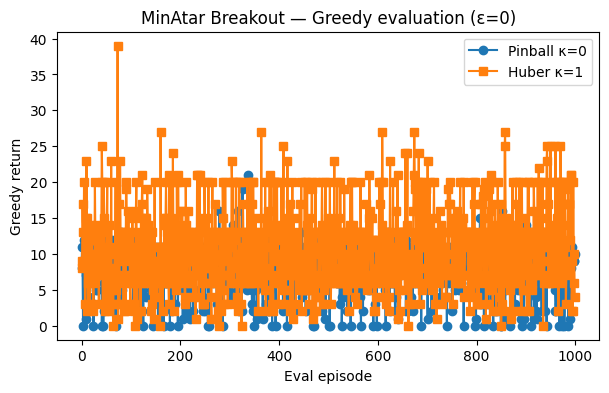

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(scores_b, marker="o", linestyle="-", label="Pinball κ=0")
plt.plot(scores_h, marker="s", linestyle="-", label="Huber κ=1")
plt.xlabel("Eval episode")
plt.ylabel("Greedy return")
plt.title("MinAtar Breakout — Greedy evaluation (ε=0)")
plt.legend()
plt.show()


CVaR-greedy evaluation (risk-aware)

In [ ]:
@torch.no_grad()
def act_greedy_cvar(state, online, alpha=0.2):
    s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)  # [1,C,H,W]
    q = online(s)  # [1,A,N]
    N = q.size(2)
    k = max(1, int(alpha * N))           # number of bottom quantiles to average
    vals = q[:, :, :k].mean(dim=2)       # [1,A] CVaR_α
    return int(vals.argmax(1).item())

@torch.no_grad()
def eval_minatar_cvar(ckpt_path, alpha=0.2, episodes=30, seed_base=54321, game="breakout", sticky=0.1):
    env = make_minatar_env(seed=seed_base, game=game, sticky=sticky)
    obs0, _ = env.reset()
    C,H,W = obs0.shape
    nA = env.action_space.n
    model = QRDQNConv(C, nA, cfg_m.n_quantiles, hidden=128).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))

    def cvar_episode(seed_offset=0):
        s, _ = env.reset(seed=seed_base + seed_offset)
        total = 0.0
        for _ in range(5000):
            a = act_greedy_cvar(s, model, alpha=alpha)
            s, r, term, trunc, _ = env.step(a)
            total += r
            if term or trunc:
                break
        return float(total)

    scores = [cvar_episode(ep) for ep in range(episodes)]
    env.close()
    import numpy as np
    scores = np.array(scores, dtype=np.float32)
    return float(scores.mean()), float(scores.std(ddof=1)), scores.tolist()

ckpt_h1 = "/content/minatar_breakout_huber_k1.pt"

mean_cvar, std_cvar, _ = eval_minatar_cvar(ckpt_h1, alpha=0.2, episodes=1000)
print(f"Huber κ=1 with CVaR(0.2): mean={mean_cvar:.2f}  std={std_cvar:.2f}")


Huber κ=1 with CVaR(0.2): mean=10.31  std=4.17
